In [3]:
pip install natsort

Note: you may need to restart the kernel to use updated packages.


# 1. Import the required libraries

In [95]:
##---------Type the code below this line------------------##
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.models import Model
from keras.layers.core import SpatialDropout2D


import tensorflow as tf
import numpy as np
import pandas as pd
import glob

import PIL
from PIL import Image

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from warnings import filterwarnings

import os
import pathlib
import natsort

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

# 2. Data Acquisition

For the problem identified by you, students have to find the data source themselves from any data source.

Provide the URL of the data used.

Write Code for converting the above downloaded data into a form suitable for DL



In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
os.environ['KAGGLE_USERNAME'] = "nirmal0"
os.environ['KAGGLE_KEY'] = "343924e88dce70f947c38e4027581239"
try:
  import kaggle
except:
  !pip install --user kaggle

!kaggle datasets download hashbanger/skin-lesion-segmentation/

100%|██████████████████████████████████████| 38.6M/38.6M [00:07<00:00, 5.69MB/s]
100%|██████████████████████████████████████| 38.6M/38.6M [00:07<00:00, 5.65MB/s]


In [8]:
os.listdir('./')

try:
  import zipfile
except:
  !pip install --user zipfile
  import zipfile

with zipfile.ZipFile('./skin-lesion-segmentation.zip', 'r') as zip_ref: zip_ref.extractall('./skin-lesion-segmentation')

In [9]:
dataset_path = './skin-lesion-segmentation'

files_trainx = natsort.natsorted(list(pathlib.Path(os.path.join(dataset_path, 'trainx')).glob('*.jpg')))
X_train = np.array([np.array(Image.open(fname)) for fname in files_trainx])

files_trainy = natsort.natsorted(list(pathlib.Path(os.path.join(dataset_path, 'trainy')).glob('*.jpg*')))
Y_train = np.array([np.array(Image.open(fname)) for fname in files_trainy])

print("Lengths:", len(X_train), len(Y_train))

Lengths: 2000 2000


# 3. Data Preparation

Perform the data prepracessing that is required for the data that you have downloaded.


This stage depends on the dataset that is used.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


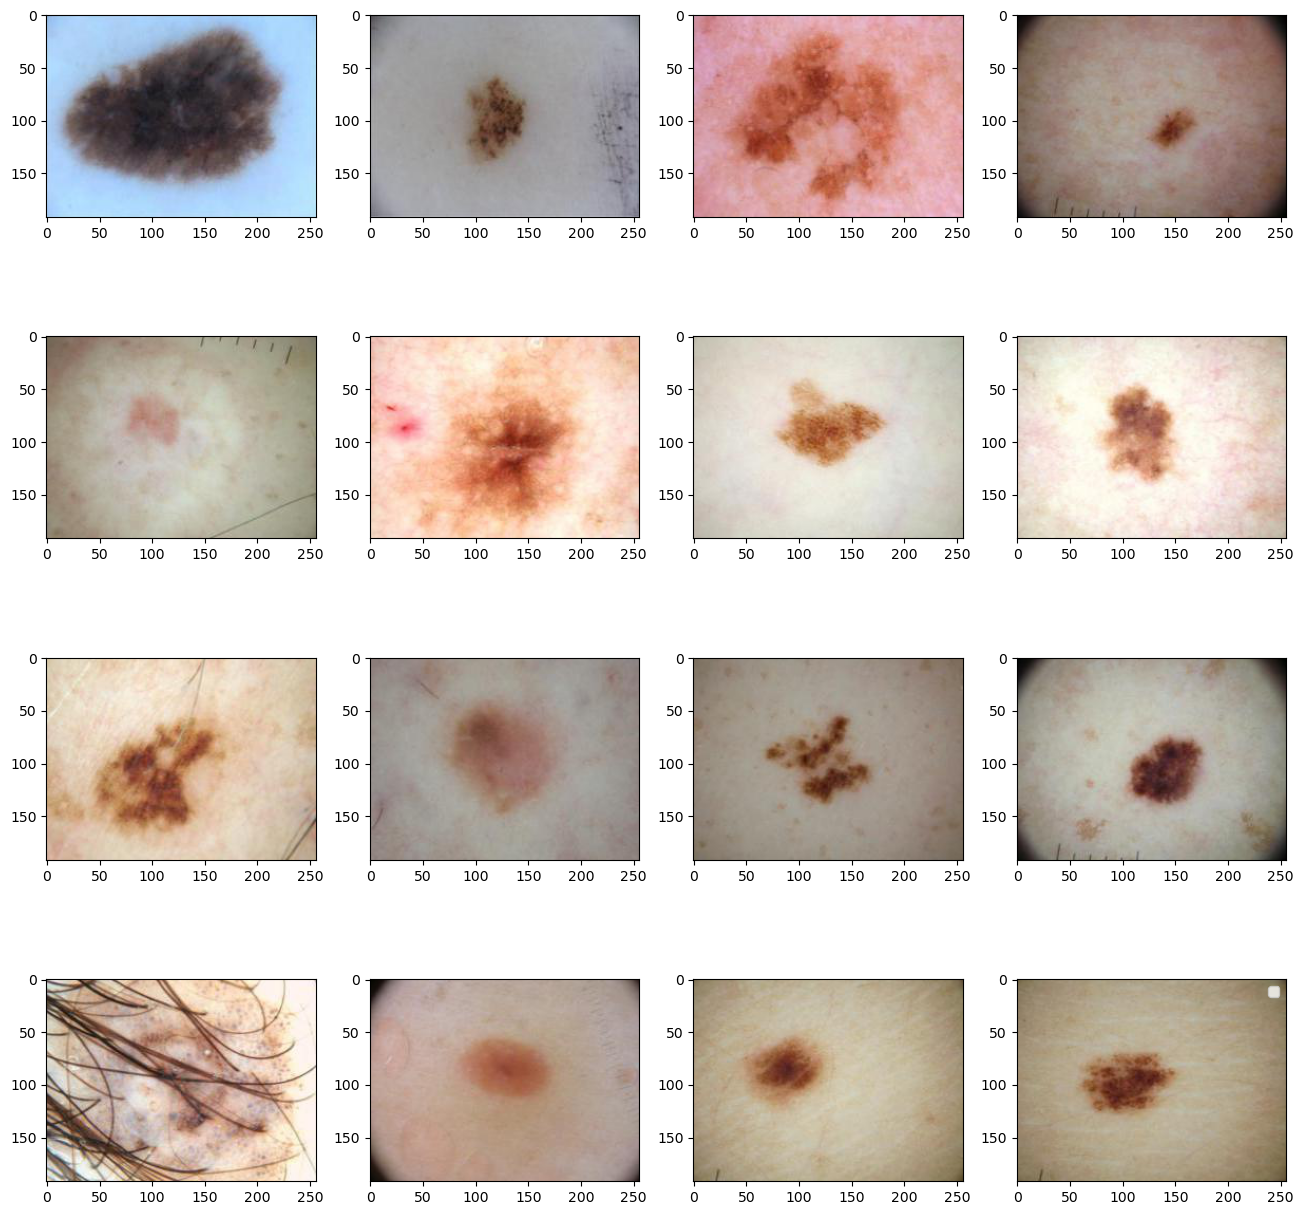

In [10]:
def show_orgnl(images):
    plt.figure(figsize = (16, 16))
    for i in range(16):
        plt.subplot(4, 4, (i + 1))
        plt.imshow(images[i],)
    plt.legend()

show_orgnl(X_train)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


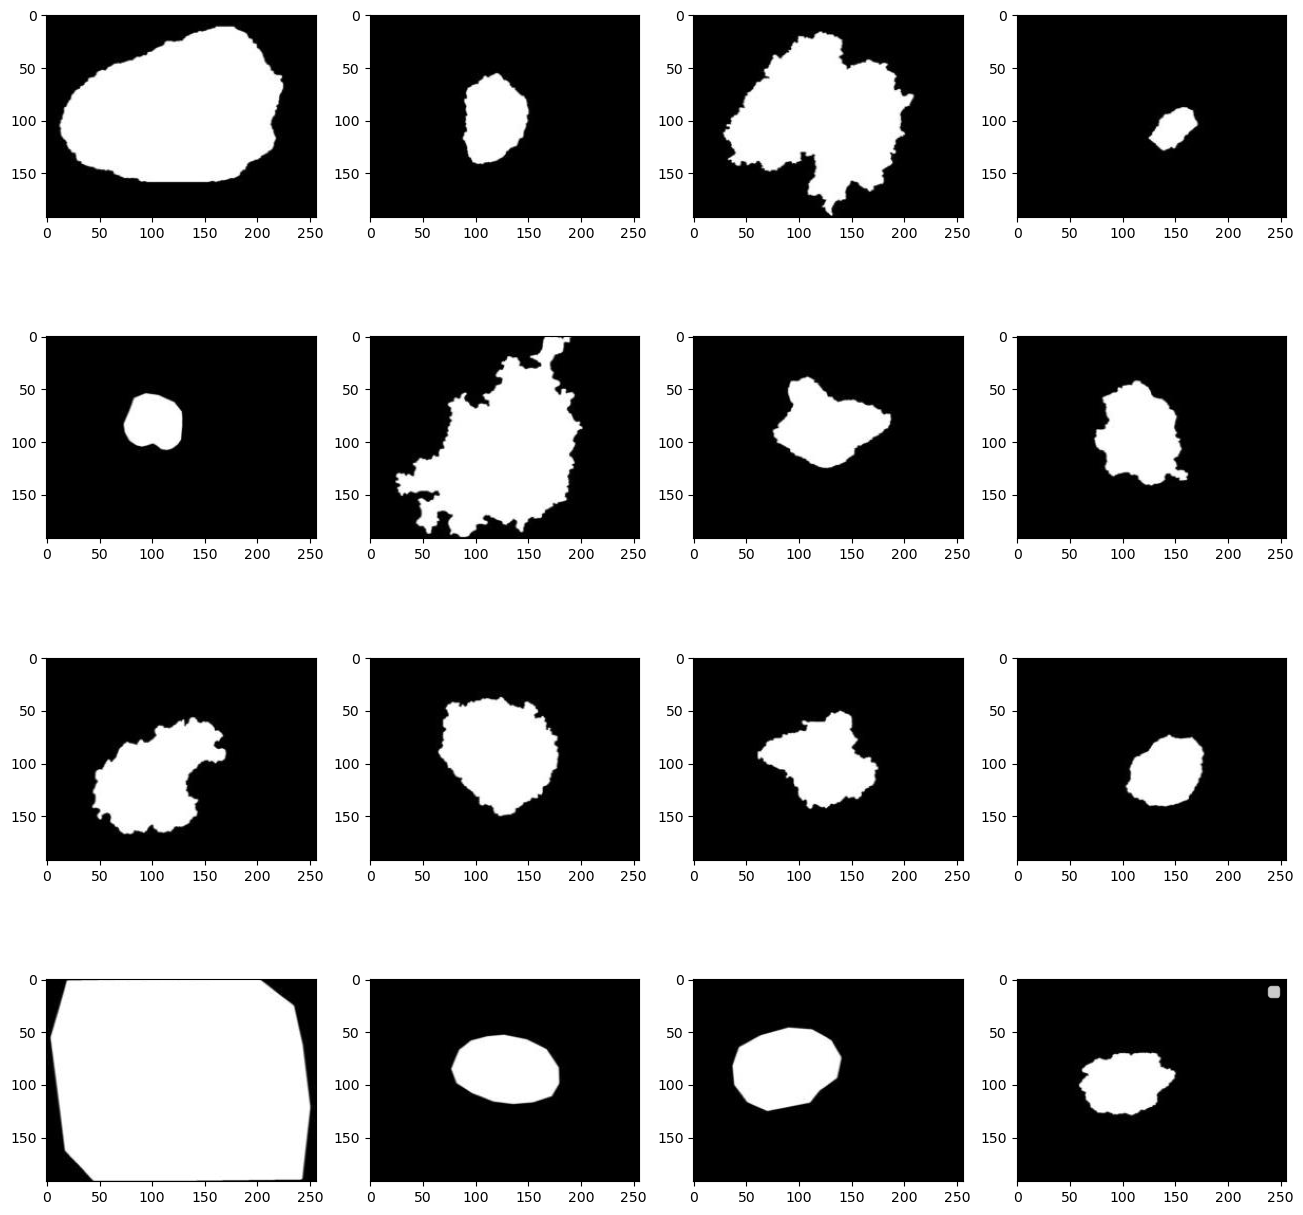

In [11]:
def show_mask(images):
    plt.figure(figsize = (16, 16))
    for i in range(16):
        plt.subplot(4, 4, (i + 1))
        plt.imshow(images[i], cmap = plt.cm.binary_r)
    plt.legend()

show_mask(Y_train)

In [12]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [14]:
## Split the data into training set and testing set
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

# Image Augmentation
# To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks.
# Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as
# random rotation, shifts, shear and flips, etc.

x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

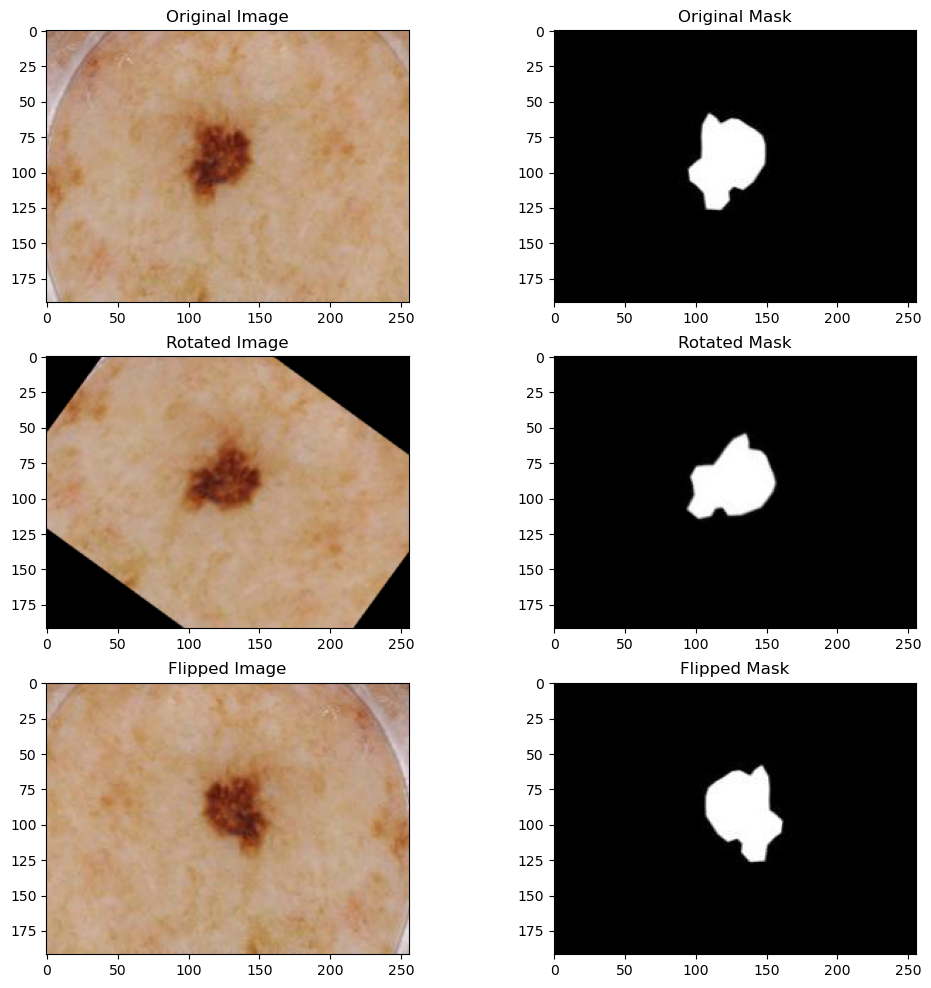

In [15]:
# Check Transformations
img_num = 7
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [22]:
#Join all the augmentations image arrays to the original training arrays.

x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

# Making a Validation Set
# Split our full training set into train and validation set. Validation dataset is used to validate the performance after each epoch.

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 9247
Length of the Test Set       : 500
Length of the Validation Set : 2312


Report the feature representation that is being used for training the model.

##---------Type below this line------------------##
#### Input Images:
The feature representation begins with the input images.
#### Preprocessing:
Prior to feeding the images into the U-Net model, preprocessing steps are applied to enhance the quality of the input data.
#### Feature Extraction:
U-Net itself is a convolutional neural network (CNN) architecture that automatically learns hierarchical feature representations from the input images. It consists of an encoder-decoder structure, where the encoder extracts features at multiple spatial scales, and the decoder recovers the spatial information while generating the segmentation mask.
#### Encoder Features:
At different levels of abstraction are extracted through a series of convolutional layers, typically using techniques like batch normalization and activation functions (e.g., ReLU). These features capture both low-level details (e.g., edges and textures) and high-level contextual information (e.g., lesion boundaries).
#### Skip Connections:
Connect corresponding encoder and decoder layers. These skip connections enable the model to preserve fine-grained details from the encoder while upscaling to generate the segmentation mask. Allow the model to combine features from different scales, improving segmentation accuracy.
#### Decoder Features:
Gradually upsamples the feature maps to the original input image resolution. Convolutional layers in the decoder refine the feature representations, gradually improving the quality of the segmentation mask.
#### Output Segmentation Mask:
The final feature representation of the model is the output segmentation mask, which is generated by the U-Net's decoder. This mask is a pixel-wise binary classification map, where each pixel is assigned a value indicating whether it belongs to the skin lesion or not. It represents the model's understanding of the lesion boundaries.
#### Ground Truth Masks:
During training, the model is supervised using ground truth segmentation masks, which are binary masks indicating the true lesion regions in the training images. These masks serve as the target for the model to learn from and are essential for calculating loss functions and updating the model's parameters during training.

## 4. Deep Neural Network Architecture


## 4.1 Design the architecture that you will be using

* CNN / RNN / Transformer as per the journal referenced



###U-Net Architecture:

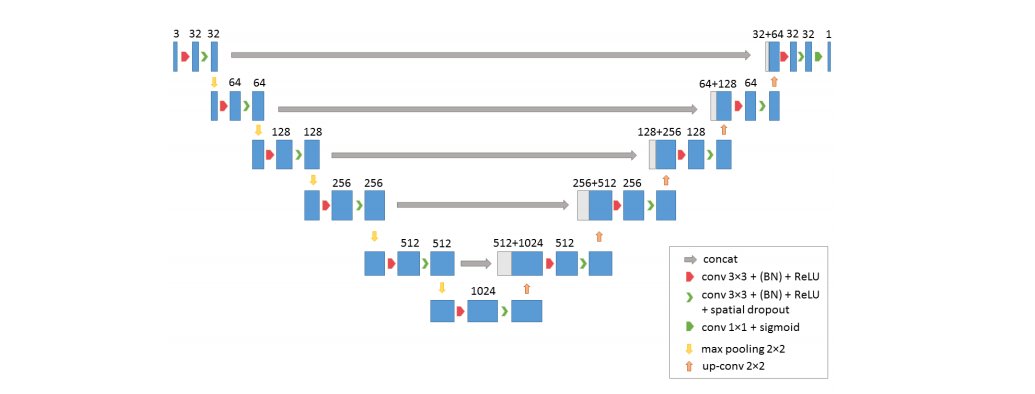

In [77]:
# how many selected items are relevant.
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# how many relevant items are selected.
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# accuracy rate across all predictions for binary classification problems
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [78]:
def UNET_Model1(savename):  
    # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= Adam(lr=0.0002), loss= ["binary_crossentropy"]
                  , metrics=[precision, recall, accuracy])
    model.summary()
    return model

In [79]:
model1 = UNET_Model1('unet_model1.h5')


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 192, 256, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 192, 256, 64)      256       
                                                                 
 activation_179 (Activation)  (None, 192, 256, 64)     0         
                                                                 
 conv2 (Conv2D)              (None, 192, 256, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 192, 256, 64)      256       
                                                                 
 activation_180 (Activation)  (None, 192, 256, 64)     0   

## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers

2. Encoder Layers: 4 sets of two consecutive Conv2D layers (each set consists of 2 layers)
3. MaxPooling Layers: 4 MaxPooling2D layers
4. 2 Dense (Fully Connected) layers
6. 4 sets of two consecutive Conv2DTranspose layers (each set consists of 2 layers)
10. The total numbers 46 layers

* Number of units in each layer

1. Encoding layer units: 4224
2. Decoding lyaer: 3713
3. COnnected layers: 2048

* Total number of trainable parameters
1.   33,377,795





# 5. Training the model

In [ ]:
hist = model1.fit(x_train, y_train, epochs= 1, batch_size= 18, validation_data=(x_val, y_val), verbose=1)
  4/514 [..............................] - ETA: 1:42:40 - loss: -53.3214 - precision: 0.6420 
                        - recall: 0.9863 - accuracy: 0.5324

###Note:
Respected evaluator/Ta, 

If we let keep training model then accuracy was also increasing but While training the model each of the Epoch taking more than 1 hr and ram usage peaks to extremly high.

we research about why U-net model take too much time to train and found some studies:
1. https://github.com/orobix/retina-unet/issues/65
2. https://discuss.pytorch.org/t/slow-training-time-for-unet-model-go-to-15-jun-2019-post/47624
Actualy require translating a Keras model and it implmentation to PyTorch to speed up training.
Other way to use prarallel distributed system to train model which we are unaware of.
Kindly consider these challenges. We are writing code how to train, test and report metrics.

# 6. Test the model


In [ ]:
##---------Type the code below this line------------------##
res_train = model1.evaluate(x_train, y_train, batch_size= 18)
  7/514 [..............................] - ETA: 34:16 - loss: -2.1400 - precision: 0.2331 
                    - recall: 1.0000 - accuracy: 0.0082

In [83]:
res_test = model1.evaluate(x_test, y_test, batch_size= 18)

28/28 [==============================] - 118s 4s/step - loss: -2.1544 - precision: 0.2301 - recall: 1.0000 - accuracy: 0.0068


In [84]:
res_val = model1.evaluate(x_val, y_val, batch_size= 18)

129/129 [==============================] - 580s 4s/step - loss: -2.0479 - precision: 0.2232 - recall: 1.0000 - accuracy: 0.0076


# 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.


#### Note: 

Since we are not able to generate history/train the model due to our conditions and limits as above said. we unable to plot Training and validation loss and accuracy, but written how to plot them.

In [ ]:
# Training loss and accuracy history.
# Validation loss and accuracy history.
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.title('Validation Accuracy')
plt.show()

In [90]:
# Report the testing accuracy and loss.
test_loss = res_test[0]
test_accuracy = res_test[3]

# Print the testing accuracy and loss
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: -2.1544
Test Accuracy: 0.0068


In [119]:
predicted_masks = model1.predict(x_test[:10])

threshold = 0.5
binary_predicted_masks = (predicted_masks > threshold).astype(int)

y_true = y_test[:10].flatten()
y_pred = binary_predicted_masks.flatten()

y_true = y_true.astype(np.int64)
y_pred = y_pred.astype(np.int64)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

1/1 [==============================] - 3s 3s/step
Accuracy: 0.006986490885416667
Precision: 0.8162379967824267
Recall: 0.006986490885416667
F1 Score: 0.000895435327078146


### NOTE


All Late Submissions will incur a <b>penalty of -2 marks </b>. So submit your assignments on time.

Good Luck